In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [25]:
import heapq

def dijkstra_grid(grid, start, end):

    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    dist = {start: 0}
    prev = {}
    heap = [(0, start)]

    while heap:
        # Pop the node with the smallest distance from the heap
        curr_dist, curr_node = heapq.heappop(heap)
        if curr_node == end:
            # We have found the shortest path to the end node
            path = []
            while curr_node in prev:
                path.append(curr_node)
                curr_node = prev[curr_node]
            path.append(start)
            return visited, path[::-1], dist[end]

        if curr_node in visited:
            # This node has already been visited
            continue

        visited.add(curr_node)

        # Visit the neighbors of the current node
        for row_offset in range(-1, 2):
            for col_offset in range(-1, 2):
                if row_offset == 0 and col_offset == 0:
                    # Skip the current node
                    continue
                neighbor_row = curr_node[0] + row_offset
                neighbor_col = curr_node[1] + col_offset
                if neighbor_row < 0 or neighbor_row >= rows or neighbor_col < 0 or neighbor_col >= cols:
                    # Neighbor is outside the grid
                    continue
                if grid[neighbor_row][neighbor_col] == 1:
                    # Neighbor is an obstacle
                    continue
                neighbor_node = (neighbor_row, neighbor_col)
                #(a)(i) just Dijkstra
                #neighbor_dist = dist[curr_node] + ((row_offset ** 2 + col_offset ** 2) ** 0.5) if row_offset != 0 and col_offset != 0 else dist[curr_node] + 1  # diagonal cost is sqrt(2) and straight cost is 1
                
                #(a)(ii) euclidean distance to goal
                #euclid = ((curr_node[0] + row_offset - end[0]) **2 + (curr_node[1] + col_offset - end[1]) **2) **0.5
                #neighbor_dist = dist[curr_node] + ((row_offset ** 2 + col_offset ** 2) ** 0.5) + euclid if row_offset != 0 and col_offset != 0 else dist[curr_node] + 1 + euclid
                
                #(a)(iii) inflated heuristic
                inflated_euclid = 100 * ((curr_node[0] + row_offset - end[0]) **2 + (curr_node[1] + col_offset - end[1]) **2) **0.5
                neighbor_dist = dist[curr_node] + ((row_offset ** 2 + col_offset ** 2) ** 0.5) + inflated_euclid if row_offset != 0 and col_offset != 0 else dist[curr_node] + 1 + inflated_euclid
                
                if neighbor_node not in visited and (neighbor_node not in dist or neighbor_dist < dist[neighbor_node]):
                    # Update the distance to the neighbor and add it to the heap
                    dist[neighbor_node] = neighbor_dist
                    prev[neighbor_node] = curr_node
                    heapq.heappush(heap, (neighbor_dist, neighbor_node))

    # No path was found from start to end
    return [], float("inf")


In [26]:
world_size = 20
grid = [[0 for x in range(world_size)] for y in range(world_size)]
for i in range(7):
    #specify obstacle coordinates
    grid[6][2+i] = 1
    grid[12][2+i] = 1
    
for i in range(5):
    grid[7+i][8] = 1
    
end = (9,4)
start = (9,14)
visited2, path2, dist2 = dijkstra_grid(grid, start, end)

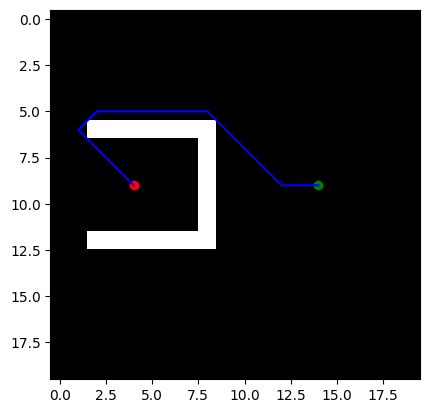

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# create a color map for the grid
cmap = plt.get_cmap("gray")

# create a new figure
fig, ax = plt.subplots()

# plot the grid as an image
ax.imshow(np.array(grid), cmap=cmap)

# plot the start and end points
ax.scatter(start[1], start[0], marker="o", color="green")
ax.scatter(end[1], end[0], marker="o", color="red")

# plot the shortest path
x = [p[1] for p in path3[::-1]]
y = [p[0] for p in path3[::-1]]
ax.plot(x, y, color="blue")

# show the plot
plt.show()

In [24]:
len(visited2)

303

In [56]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt


class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None


class RRT:
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=20, max_iter=1000):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.min_rand_x, self.max_rand_x = rand_area[0], rand_area[2]
        self.min_rand_y, self.max_rand_y = rand_area[1], rand_area[3]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list

        self.node_list = [self.start]

        for i in range(self.max_iter):
            if random.randint(0, 100) > self.goal_sample_rate:
                rand_node = self.get_random_node()
            else:
                rand_node = self.goal

            nearest_ind = self.get_nearest_node_index(self.node_list, rand_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rand_node, self.expand_dis)
            if self.check_collision(new_node, self.obstacle_list):
                self.node_list.append(new_node)

            if self.calc_dist_to_goal(self.node_list[-1].x, self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.goal, self.expand_dis)
                if self.check_collision(final_node, self.obstacle_list):
                    self.node_list.append(final_node)
                    break

        self.path = self.get_path(self.node_list[-1])

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = [random.uniform(self.min_rand_x, self.max_rand_x), random.uniform(self.min_rand_y, self.max_rand_y)]
        else:
            rnd = [self.goal.x, self.goal.y]
        return Node(rnd[0], rnd[1])

    def get_nearest_node_index(self, node_list, rnd_node):
        dlist = [(node.x - rnd_node.x) ** 2 + (node.y - rnd_node.y) ** 2 for node in node_list]
        minind = dlist.index(min(dlist))
        return minind

    def steer(self, from_node, to_node, extend_length=float("inf")):
        new_node = Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)
        if extend_length > d:
            extend_length = d
        new_node.x += extend_length * math.cos(theta)
        new_node.y += extend_length * math.sin(theta)
        new_node.parent = from_node
        return new_node

    def calc_distance_and_angle(self, from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        return math.sqrt(dx ** 2 + dy ** 2), math.atan2(dy, dx)

    def check_collision(self, node, obstacle_list):
        for obstacle in obstacle_list:
            if self.dist_to_obstacle(node.x, node.y, obstacle) <= 0.5:
                return


In [57]:
start = (9,4)
goal = (9,14)
obstacle_list = [(6,2,7,1), (12,2,7,1), (7,8,1,5)]
rand_area = (0, 0, 20, 20)


def get_path(goal_node):
    path = []
    node = goal_node
    while node.parent is not None:
        path.append((node.x, node.y))
        node = node.parent
    path.append((node.x, node.y))
    return path[::-1]


rrt = RRT(start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=200, max_iter=1000000)
path = get_path(rrt.node_list[-1])


AttributeError: 'RRT' object has no attribute 'dist_to_obstacle'

In [55]:
path

[(9, 4)]